# Mini Project 1

Dataset Requirements:
	From API

Presentation (5 min):
	From Jupyter Notebook

Techniques:
	Things learnt so far
> EDA    
> Data cleaning & profiling    
> Hypothesis testing    
> Data visualisation    
> SQL    
> API


Structure:
>Questions    
>Dataset & Analysis    
>Conclusion

Due Data:
	2 July 2021
***

<b>Dataset</b>: Building Energy Efficiency Register <br>
<b>Source</b>: Commercial Building Disclosure (CBD) Program

<b>Background</b>: The Commercial Building Disclosure (CBD) Program requires energy efficiency information to be provided in most cases when commercial office space of 1000 square metres or more is offered for sale or lease. The aim is to improve the energy efficiency of Australia's large office buildings and to ensure prospective buyers and tenants are informed.

## Questions:
- Is there a relationship between building size and energy consumption / CO2 emission?
- What is the difference of energy efficiency between different states?
- What features have high correlation with the energy consumption and CO2 emission?
- What is the mean energy efficiency in SA?
- What is the most/least energy efficient building in SA?
- Is there a significant difference between SA CBD and suburbs?
- What is the trend of energy efficiency over time?

## Data Exploration:

In [1]:
# Import libraries
import requests
import json
from datetime import datetime, date
import pandas as pd
import numpy as np
import sqlite3
from pandas.io import sql
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Resource ID of the dataset
resource_id = "cf578be8-497b-4d3a-8527-a6338e1001bb"

Obtain data that is not expired

In [3]:
# The datetime format on the dataset is dd/mm/yyyy hh:mm, but SQL defaut datetime format is yyyy/mm/dd HH:mm.
# This misalignment caused issue when filtering results using WHERE "CRT_UTC_CurrentTo" > 'today'.
# The server doesn't have CONVERT() function to alter datetime style.
# Solution: Use LIKE function to get around.
#           Since a Building Energy Efficiency Certificate is only valid for 12 month, this method is viable.

# Data used: "Building Name", "Building Address", "Building Geocode", "Certificate No.", "Certificate Due Date"
#            "NABERS Rating Scope", "NABERS Rating", "NABERS Rated Area", "Annual Emissions", "Annual Consumption"

# Query job
url = """
        https://data.gov.au/data/api/3/action/datastore_search_sql?sql=
        SELECT "B_ShortName", "B_StreetAddress", "B_Suburb", "B_PostCode", "B_State", "B_Geocode", "CRT_CertificateNumber", "CRT_UTC_CurrentTo",
               "CRT_Nabers_RatingScope", "CRT_Nabers_StarRating", "CRT_Nabers_RatedArea", "CRT_Nabers_AnnualEmissions", "CRT_Nabers_AnnualConsumption"
        FROM "{}"
        WHERE "CRT_UTC_CurrentTo" LIKE '%25202%25'
        ;
      """
url = url.format(resource_id)
response = requests.get(url)

# Convert response to dict
json_data = response.json()

In [4]:
# Convert dict to dataframe
df = pd.DataFrame.from_dict(json_data)
df

,help,success,result
\n,https://data.gov.au/data/api/3/action/help_sho...,True,
fields,https://data.gov.au/data/api/3/action/help_sho...,True,"[{'type': 'text', 'id': 'B_ShortName'}, {'type..."
records,https://data.gov.au/data/api/3/action/help_sho...,True,"[{'B_State': 'NSW', 'CRT_Nabers_RatedArea': '1..."
sql,https://data.gov.au/data/api/3/action/help_sho...,True,"\n SELECT ""B_ShortName"", ""B_StreetAddre..."


In [5]:
# Extract records
rec = df.loc["records","result"]

# Build a dataframe for records
df_rec = pd.DataFrame.from_dict(rec)
df_rec

,B_State,CRT_Nabers_RatedArea,B_ShortName,CRT_Nabers_AnnualConsumption,B_PostCode,B_Geocode,CRT_Nabers_RatingScope,B_Suburb,CRT_Nabers_StarRating,CRT_CertificateNumber,B_StreetAddress,CRT_UTC_CurrentTo,CRT_Nabers_AnnualEmissions
0,NSW,14958.9,Bay Centre,2064328.2,2009,GANSW715687035,Base Building,Pyrmont,6,B0399-2020/11,65 Pirrama Road,18/07/2021 14:00,439878
1,NSW,31300.7,45 Clarence Street,8670293.9,2000,GANSW706008612,Base Building,Sydney,5,B1084-2020/10,45 Clarence Street,3/11/2021 3:40,1680616
2,VIC,40142.1,180 Lonsdale Street,15414566.4,3000,GAVIC422447471,Base Building,Melbourne,4.5,B1309-2019/9,180 Lonsdale Street,27/10/2020 13:00,2848799
3,NSW,45486,Qantas Corporate Centre,35297136,2020,GANSW710372086,Whole Building,Mascot,5.5,B2923-2021/1,203 Coward Street,14/09/2021 14:00,5777819
4,VIC,1215.9,"71 Bridge Street, Bendigo",746562.6,3550,GAVIC425668862,Whole Building,Bendigo,4.5,B2916-2021/1,71 Bridge Street,29/11/2021 13:00,183160
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49602,NSW,56894.7,None,19002829.8,2000,GANSW710270828,Base Building,Sydney,5,B1673-2020/8,161 Castlereagh Street,3/11/2021 3:44,3157982
49603,NSW,56894.7,None,19002829.8,2000,GANSW710270828,Base Building,Sydney,5,B1673-2020/8,161 Castlereagh Street,3/11/2021 3:44,3157982
49604,QLD,2519,100 George Street,1035309,4207,GAQLD162468047,Base Building,Beenleigh,4,B1290-2020/8,100 George Street,14/10/2021 13:00,233368
49605,NSW,14368.6,None,3276040.8,2113,GANSW706465330,Base Building,Macquarie Park,5.5,B0784-2020/8,78 Waterloo Road,4/02/2021 13:00,703116


Explore dataframe

In [6]:
df_rec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49607 entries, 0 to 49606
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   B_State                       49607 non-null  object
 1   CRT_Nabers_RatedArea          49607 non-null  object
 2   B_ShortName                   32379 non-null  object
 3   CRT_Nabers_AnnualConsumption  49607 non-null  object
 4   B_PostCode                    49607 non-null  object
 5   B_Geocode                     48462 non-null  object
 6   CRT_Nabers_RatingScope        49607 non-null  object
 7   B_Suburb                      49607 non-null  object
 8   CRT_Nabers_StarRating         49607 non-null  object
 9   CRT_CertificateNumber         49607 non-null  object
 10  B_StreetAddress               49607 non-null  object
 11  CRT_UTC_CurrentTo             49607 non-null  object
 12  CRT_Nabers_AnnualEmissions    49607 non-null  object
dtypes: object(13)
me

Convert data type for later use

In [7]:
# Remain unchanged: "Building Name", "Building Address", "B_Geocode", "Certificate No.", "NABERS Rating Scope"
# Change to datetime: "Certificate Due Date"
# Change to float: "NABERS Rating", "NABERS Rated Area", "Annual Emissions", "Annual Consumption"

# Convert values under "CRT_UTC_CurrentTo" to datetime
for ind in df_rec.index:
    d = df_rec.loc[ind , "CRT_UTC_CurrentTo"]
    d = datetime.strptime(d, "%d/%m/%Y %H:%M").date()
    df_rec.loc[[ind], ["CRT_UTC_CurrentTo"]] = d

# Convert "CRT_UTC_CurrentTo" column to datetime
df_rec["CRT_UTC_CurrentTo"] = pd.to_datetime(df_rec["CRT_UTC_CurrentTo"])

# Convert numerical columns to float
float_column = ["CRT_Nabers_StarRating", "CRT_Nabers_RatedArea", "CRT_Nabers_AnnualEmissions", "CRT_Nabers_AnnualConsumption"]

for i in df_rec.columns:
    if i in float_column:
        df_rec[i] = df_rec[i].astype(float)

In [8]:
df_rec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49607 entries, 0 to 49606
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   B_State                       49607 non-null  object        
 1   CRT_Nabers_RatedArea          49607 non-null  float64       
 2   B_ShortName                   32379 non-null  object        
 3   CRT_Nabers_AnnualConsumption  49607 non-null  float64       
 4   B_PostCode                    49607 non-null  object        
 5   B_Geocode                     48462 non-null  object        
 6   CRT_Nabers_RatingScope        49607 non-null  object        
 7   B_Suburb                      49607 non-null  object        
 8   CRT_Nabers_StarRating         49607 non-null  float64       
 9   CRT_CertificateNumber         49607 non-null  object        
 10  B_StreetAddress               49607 non-null  object        
 11  CRT_UTC_CurrentTo           

Remove expired certificates

In [9]:
# Today's date in numpy datetime64 format
today = np.datetime64(datetime.today().date())
print(today)

df_valid = df_rec[df_rec["CRT_UTC_CurrentTo"] >= today]
df_valid

2021-07-02


,B_State,CRT_Nabers_RatedArea,B_ShortName,CRT_Nabers_AnnualConsumption,B_PostCode,B_Geocode,CRT_Nabers_RatingScope,B_Suburb,CRT_Nabers_StarRating,CRT_CertificateNumber,B_StreetAddress,CRT_UTC_CurrentTo,CRT_Nabers_AnnualEmissions
0,NSW,14958.90,Bay Centre,2064328.2,2009,GANSW715687035,Base Building,Pyrmont,6.0,B0399-2020/11,65 Pirrama Road,2021-07-18,439878.000
1,NSW,31300.70,45 Clarence Street,8670293.9,2000,GANSW706008612,Base Building,Sydney,5.0,B1084-2020/10,45 Clarence Street,2021-11-03,1680616.000
3,NSW,45486.00,Qantas Corporate Centre,35297136.0,2020,GANSW710372086,Whole Building,Mascot,5.5,B2923-2021/1,203 Coward Street,2021-09-14,5777819.000
4,VIC,1215.90,"71 Bridge Street, Bendigo",746562.6,3550,GAVIC425668862,Whole Building,Bendigo,4.5,B2916-2021/1,71 Bridge Street,2021-11-29,183160.000
5,VIC,59249.32,Melbourne Central Tower,13331097.0,3000,GAVIC411824557,Base Building,Melbourne,5.0,B1375-2020/11,360 Elizabeth Street,2021-12-15,2846468.173
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49600,VIC,14189.10,None,6314149.5,3179,GAVIC719049683,Base Building,Scoresby,4.5,B2836-2020/1,35 Dalmore Drive,2021-08-31,972908.000
49602,NSW,56894.70,None,19002829.8,2000,GANSW710270828,Base Building,Sydney,5.0,B1673-2020/8,161 Castlereagh Street,2021-11-03,3157982.000
49603,NSW,56894.70,None,19002829.8,2000,GANSW710270828,Base Building,Sydney,5.0,B1673-2020/8,161 Castlereagh Street,2021-11-03,3157982.000
49604,QLD,2519.00,100 George Street,1035309.0,4207,GAQLD162468047,Base Building,Beenleigh,4.0,B1290-2020/8,100 George Street,2021-10-14,233368.000


Only one certificate per building. The latest certificate remains valid and the others would become expired.

In [10]:
# Find out what building has more than 1 certificate due date
geo_grp = df_valid.groupby("B_Geocode").nunique()
more_than_1_cert = geo_grp[geo_grp["CRT_UTC_CurrentTo"] > 1]
illegal_list = more_than_1_cert.index.tolist()
df_ill = df_valid[df_valid["B_Geocode"].isin(illegal_list)]

# Find the latest certificate of those buildings by expiry date (Only the latest certificate is valid!)
latest_cert = df_ill.groupby("B_Geocode")["CRT_UTC_CurrentTo"].max()
latest_cert

B_Geocode
GAACT714964884   2022-02-25
GANSW710270405   2022-04-29
GANSW710270828   2021-11-03
GANSW710288458   2022-04-08
GANSW713070125   2021-12-17
GANSW713107326   2022-04-05
GAQLD155548728   2022-02-10
GAQLD163214137   2022-04-05
GASA_421964393   2022-04-27
GAVIC419796857   2022-05-12
GAWA_146651601   2021-11-25
GAWA_148318149   2022-05-17
GAWA_161507589   2022-04-07
Name: CRT_UTC_CurrentTo, dtype: datetime64[ns]

In [11]:
# Filter out rows with invalid certificate due to a newer certificate exists
for i in illegal_list:
    bad_ind = df_ill[(df_ill["B_Geocode"] == i) & (df_ill["CRT_UTC_CurrentTo"] != latest_cert[i])].index
    df_valid = df_valid.drop(bad_ind)

Some buildings have more than one row because they have mulitple functional areas hence multiple Tenancy Lighting Assessment (TLA). This assessment evaluates the power density and capacity of installed lighting control systems. As a result, many data are duplicated.

In [12]:
# Remove duplicated
df_valid.drop_duplicates(subset=["B_Geocode"], keep='first', inplace=True, ignore_index=True)

In [13]:
# Clean dataset
df_valid

,B_State,CRT_Nabers_RatedArea,B_ShortName,CRT_Nabers_AnnualConsumption,B_PostCode,B_Geocode,CRT_Nabers_RatingScope,B_Suburb,CRT_Nabers_StarRating,CRT_CertificateNumber,B_StreetAddress,CRT_UTC_CurrentTo,CRT_Nabers_AnnualEmissions
0,NSW,14958.90,Bay Centre,2064328.2,2009,GANSW715687035,Base Building,Pyrmont,6.0,B0399-2020/11,65 Pirrama Road,2021-07-18,439878.000
1,NSW,31300.70,45 Clarence Street,8670293.9,2000,GANSW706008612,Base Building,Sydney,5.0,B1084-2020/10,45 Clarence Street,2021-11-03,1680616.000
2,NSW,45486.00,Qantas Corporate Centre,35297136.0,2020,GANSW710372086,Whole Building,Mascot,5.5,B2923-2021/1,203 Coward Street,2021-09-14,5777819.000
3,VIC,1215.90,"71 Bridge Street, Bendigo",746562.6,3550,GAVIC425668862,Whole Building,Bendigo,4.5,B2916-2021/1,71 Bridge Street,2021-11-29,183160.000
4,VIC,59249.32,Melbourne Central Tower,13331097.0,3000,GAVIC411824557,Base Building,Melbourne,5.0,B1375-2020/11,360 Elizabeth Street,2021-12-15,2846468.173
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,SA,1848.70,None,1164681.0,5034,GASA_422263858,Whole Building,Wayville,3.5,B2921-2021/1,24-25 Greenhill Road,2022-04-29,139416.000
1189,VIC,590.30,None,370708.4,3145,GAVIC421263660,Whole Building,Malvern East,3.0,B2509-2020/3,207-213 Waverley Road,2021-12-07,105179.000
1190,VIC,254.50,None,229304.5,3124,GAVIC422021363,Whole Building,Camberwell,1.0,B2933-2021/1,357 Camberwell Road,2022-05-18,64991.000
1191,QLD,3137.60,None,1844908.8,4131,GAQLD163175930,Whole Building,Meadowbrook,5.0,B1847-2020/2,3-19 University Drive,2021-08-02,415113.000


In [14]:
print(f"The dataset has been reduced from {len(df_rec.index)} rows to {len(df_valid.index)}.\n\
Afterall, the total number of unique buildings is only {df_rec['B_Geocode'].nunique()}")

The dataset has been reduced from 49607 rows to 1193.
Afterall, the total number of unique buildings is only 1669


In [15]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1193 entries, 0 to 1192
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   B_State                       1193 non-null   object        
 1   CRT_Nabers_RatedArea          1193 non-null   float64       
 2   B_ShortName                   706 non-null    object        
 3   CRT_Nabers_AnnualConsumption  1193 non-null   float64       
 4   B_PostCode                    1193 non-null   object        
 5   B_Geocode                     1192 non-null   object        
 6   CRT_Nabers_RatingScope        1193 non-null   object        
 7   B_Suburb                      1193 non-null   object        
 8   CRT_Nabers_StarRating         1193 non-null   float64       
 9   CRT_CertificateNumber         1193 non-null   object        
 10  B_StreetAddress               1193 non-null   object        
 11  CRT_UTC_CurrentTo             

### Is there a relationship between building size and energy consumption / CO2 emission?

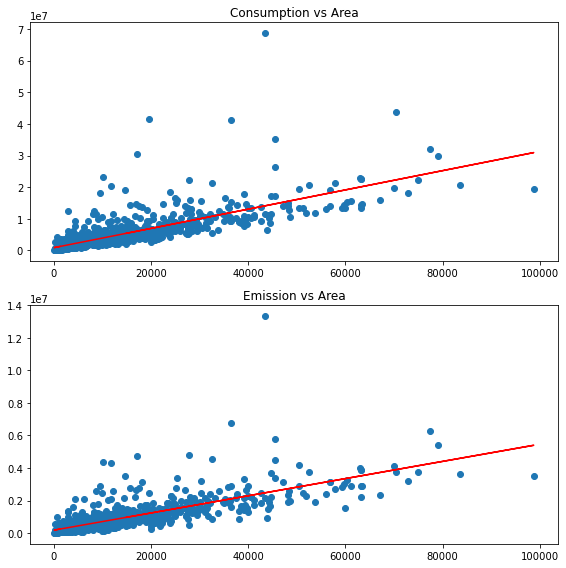

In [16]:
# Give area, consumption and emission a name
area = df_valid["CRT_Nabers_RatedArea"]
consumption = df_valid["CRT_Nabers_AnnualConsumption"]
emission = df_valid["CRT_Nabers_AnnualEmissions"]

# Find polyfit line
m1, c1 = np.polyfit(area, consumption, 1)
m2, c2 = np.polyfit(area, emission, 1)

# Visualise the relationship between consumption/emission and building size
fig = plt.figure(figsize=(8, 8))

ax1 = fig.add_subplot(211)
ax1 = plt.scatter(x=area, y=consumption)
ax1 = plt.plot(area, area*m1+c1, color='red')
ax1 = plt.title("Consumption vs Area")

ax2 = fig.add_subplot(212)
ax2 = plt.scatter(x=area, y=emission)
ax1 = plt.plot(area, area*m2+c2, color='red')
ax2 = plt.title("Emission vs Area")

fig.tight_layout()
plt.show()

Larger buildings tend to consume more energy and emit more CO2

### What is the difference of energy efficiency between different states?

In [17]:
# Create new feature "consumption_per_area"
consumption_per_area = consumption / area
df_valid["consumption_per_area"] = consumption_per_area
cpa = df_valid["consumption_per_area"]

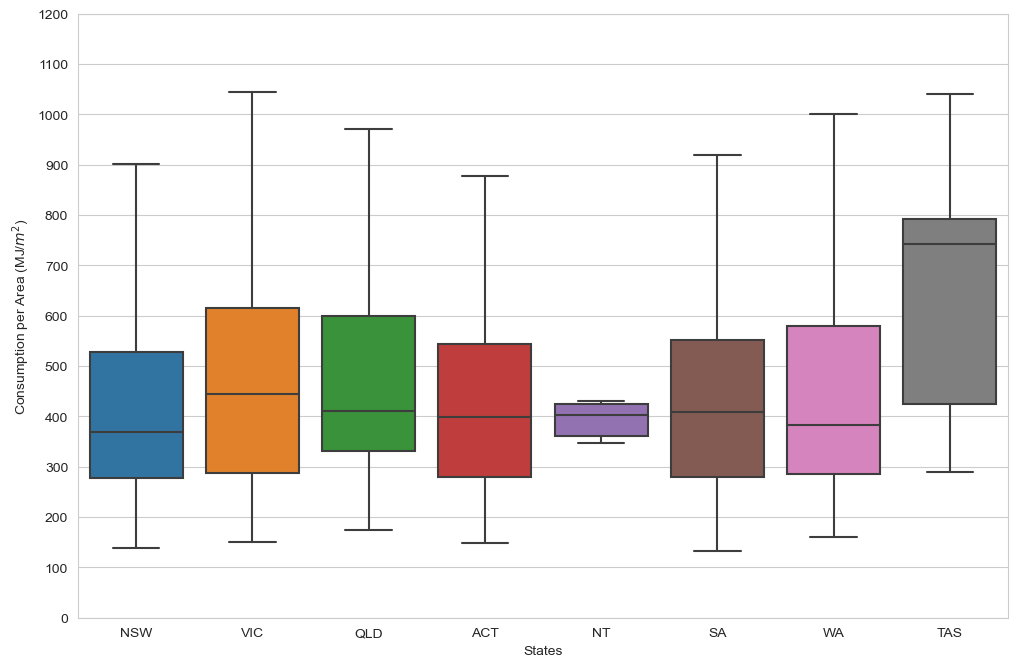

In [18]:
fig = plt.figure(figsize=(12,8), dpi= 100)
sns.set_style("whitegrid")
ax = sns.boxplot(x="B_State", y="consumption_per_area", data=df_valid, showfliers = False)
plt.xlabel("States")
plt.ylabel("Consumption per Area (MJ/$m^2$)")
plt.yticks(np.linspace(0, 1200, 13))
plt.show()

Most states have similar energy efficiency, with median energy consumption around 400 $MJ/m^2$ per year, except TAS which is significantly higher. It may be because of the small sample size of TAS buildings.

In [19]:
print("TAS sample size: {}".format(df_valid[df_valid["B_State"] == "TAS"].shape[0]))

TAS sample size: 11


### What features have high correlation with the energy consumption and CO2 emission?

In [20]:
## Create new features "state_num"

# Assign each state a number
states = {}
for i in range(df_valid["B_State"].nunique()):
    states[df_valid["B_State"].unique()[i]] = i+1
print(states)

# Create "state_num"
state_num = []
for ind in df_valid.index:
    state_num.append(states[df_valid.loc[ind, "B_State"]])
    
# Add "state_num" to df_valid
df_valid["state_num"] = state_num

{'NSW': 1, 'VIC': 2, 'QLD': 3, 'ACT': 4, 'NT': 5, 'SA': 6, 'WA': 7, 'TAS': 8}


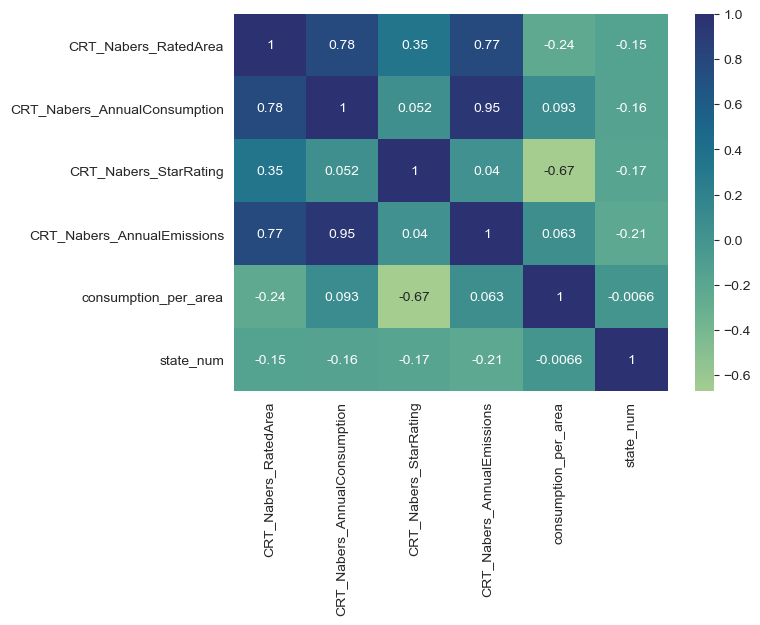

In [21]:
# Find correlation between columns
corr = df_valid.corr()

plt.figure(figsize=(7,5), dpi= 100)
sns.heatmap(corr, annot=True, cmap="crest")
plt.show()

According to the figure above, <b>Energy Consumption</b> and <b>CO2 Emission</b> are strongly related. In addition, <b>Area</b> also has a significant influence on both of these features.

It can be further investigated by considering suburbs. However, it needs more knowledge of Australian district in order to do so.

### What is the mean energy efficiency in SA?

In [22]:
# Mean energy efficiency of all states
print("Mean energy efficiency of all states: {}".format(df_valid["consumption_per_area"].mean()))

# Median energy efficiency of all states
print("Median energy efficiency of all states: {}".format(df_valid["consumption_per_area"].median()))

print("")

# Mean energy efficiency of SA
df_sa = df_valid[df_valid["B_State"] == "SA"]
print("Mean energy efficiency of SA: {}".format(df_sa["consumption_per_area"].mean()))

# Median energy efficiency of SA
print("Median energy efficiency of SA: {}".format(df_sa["consumption_per_area"].median()))

Mean energy efficiency of all states: 498.86923721702215
Median energy efficiency of all states: 395.0

Mean energy efficiency of SA: 468.5151515151515
Median energy efficiency of SA: 408.5


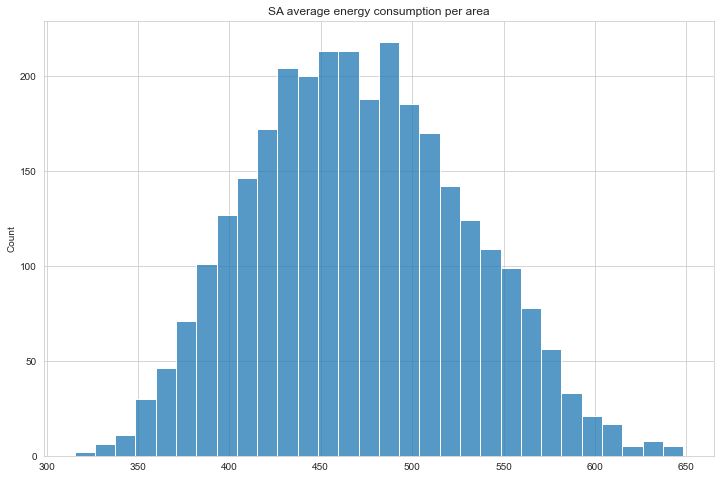

In [23]:
## Sampling

# Set size and samples
size = 20
n = 3000

# Create empty list for sampling means
sampling_means = []

for i in range(n):
    result = df_sa["consumption_per_area"].sample(size)
    result_mean = result.mean()
    sampling_means.append(result_mean)

plt.figure(figsize=(12, 8))
sns.histplot(sampling_means)
plt.title("SA average energy consumption per area")
plt.show()

### What is the most/least energy efficient building in SA?

In [24]:
# Create SQL database
sqlite_db = "beer.sqlite"
# Connect to database "beer.sqlite". If doesn't exist, create one
conn = sqlite3.connect(sqlite_db) 
# Create a cursor
c = conn.cursor()

In [25]:
# Copy dataframe to SQL table
df_sa.to_sql("sa", con = conn, if_exists = 'replace', index = False)

In [26]:
# Query buildings with max/min energy consumption per area
query = "SELECT B_Geocode, MAX(consumption_per_area) FROM sa;"
rs = c.execute(query)
b_max = rs.fetchall()[0][0]

query = "SELECT B_Geocode, MIN(consumption_per_area) FROM sa;"
rs = c.execute(query)
b_min = rs.fetchall()[0][0]

df_sa[(df_sa["B_Geocode"] == b_max) | (df_sa["B_Geocode"] == b_min)].sort_values("B_Geocode")

,B_State,CRT_Nabers_RatedArea,B_ShortName,CRT_Nabers_AnnualConsumption,B_PostCode,B_Geocode,CRT_Nabers_RatingScope,B_Suburb,CRT_Nabers_StarRating,CRT_CertificateNumber,B_StreetAddress,CRT_UTC_CurrentTo,CRT_Nabers_AnnualEmissions,consumption_per_area,state_num
986,SA,846.4,None,1492203.2,5000,GASA_416457935,Whole Building,Adelaide,0.0,B2719-2021/2,139 Frome Street,2022-02-08,175491.0,1763.0,6
851,SA,19951.5,70 Franklin,2633598.0,5000,GASA_416458284,Base Building,Adelaide,6.0,B1770-2020/6,70 Franklin Street,2021-07-23,267806.0,132.0,6


139 Frome Street, Adelaide SA 5000 has the lowest energy efficiency, while <br> 70 Franklin Street, Adelaide SA 5000 has the highest energy efficiency.

### Is there a significant difference between SA CBD and suburbs?

In [27]:
# Query energy efficiency of CBD and Suburbs
query = "SELECT consumption_per_area FROM sa WHERE B_Suburb = 'Adelaide';"
rs = c.execute(query)
cbd = rs.fetchall()

query = "SELECT consumption_per_area FROM sa WHERE B_Suburb != 'Adelaide';"
rs = c.execute(query)
sub = rs.fetchall()

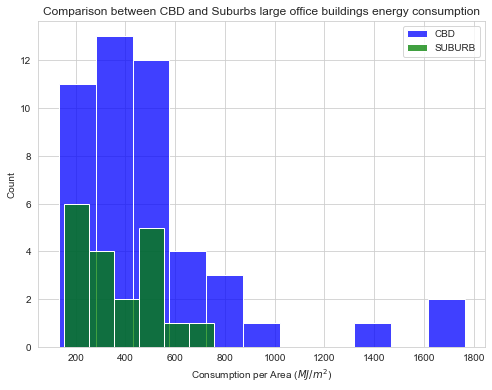

In [28]:
cbd = np.array(cbd).flatten()
sub = np.array(sub).flatten()

plt.figure(figsize=(8, 6))
ax = sns.histplot(cbd, color="b")
ax = sns.histplot(sub, color="g")
ax.legend(("CBD", "SUBURB"))
plt.xlabel("Consumption per Area ($MJ/m^2$)")
plt.title("Comparison between CBD and Suburbs large office buildings energy consumption")
plt.show()

**Define hypothesis:**<br>
H0: There is no difference between energy efficiency of large office buildings  in `CBD` and `Suburbs`<br>
H1: There is difference between energy efficiency of large office buildings  in `CBD` and `Suburbs`

**Alpha** = 0.05

In [29]:
# T-Test
alpha = 0.05
t, p = stats.ttest_ind(cbd, sub)

print("t-value: {}, p-value: {}".format(t, p))
if p < alpha:
    print("Reject H0")
elif p > alpha:
    print("Fail to reject H0")
else:
    print("Inconclusive")

t-value: 1.628720330394784, p-value: 0.10828532351677594
Fail to reject H0


The result suggests that there is no difference between energy efficiency of large office buildings in CBD and Suburbs

### What is the trend of energy efficiency over time?

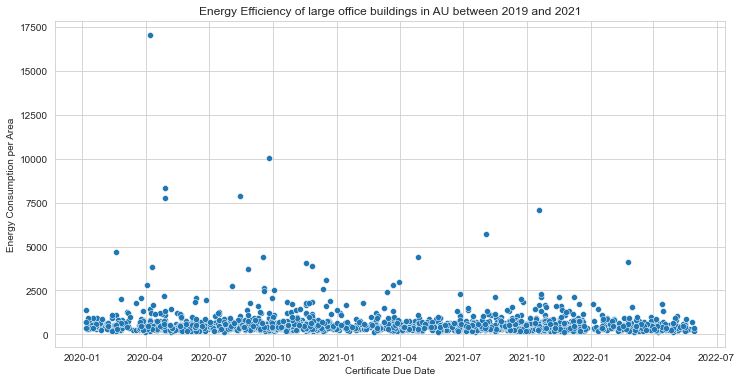

In [30]:
# Remove duplicated data
building_all = df_rec.drop_duplicates(subset=["B_Geocode"], keep='first', inplace=False, ignore_index=True)

# Calculate Energy Consumption / Area for all data
all_effi = building_all["CRT_Nabers_AnnualConsumption"] / building_all["CRT_Nabers_RatedArea"]

fig = plt.figure(figsize=(12, 6))
sns.scatterplot(x="CRT_UTC_CurrentTo", y=all_effi, data=building_all)
plt.xlabel("Certificate Due Date")
plt.ylabel("Energy Consumption per Area")
plt.title("Energy Efficiency of large office buildings in AU between 2019 and 2021")
plt.show()

No significant trend was found. It suggests that a noticeable change will not happen in near future.

## Conclusion:

Large office buildings over most states have similar energy efficiency. Although TAS has a significant higher result, the sample size is too small to judge.

Overall SA large office buildings are not more/less energy efficienct than those in other states.

139 Frome Street, Adelaide SA 5000 has the lowest energy efficiency, while 70 Franklin Street, Adelaide SA 5000 has the highest energy efficiency.

There is no significant difference in energy efficiency between SA large office buildings in CBD and outside CBD. However, a few buildings in the CBD consume a lot more energy per year.

The energy efficiency of Australian large office buildings will not have a significant change any time soon.